## Rendering images from 3D shapes using Pytorch3D

In this notebook we are going to get hands on with Pytorch3D and its rendering machine. This notebook will play a crucial role when we implement MVCNN paper in the next notebook.

**Purpose**: To extract different viewed images from 3D shapes.

A lot of credit goes to **Adele Kuzmiakova** and [her medium blog](https://towardsdatascience.com/how-to-render-3d-files-using-pytorch3d-ef9de72483f8) which acted as a backbone for this notebook. 

*_Ofcourse as a first step we are going to import all the necessary packages in the first cell._*

In [1]:
## Importing necessary packages ##

import torch
import pytorch3d
from pytorch3d.io import load_obj
from pytorch3d.structures import Meshes
from pytorch3d.renderer import TexturesAtlas
from pytorch3d.renderer.cameras import look_at_view_transform , FoVPerspectiveCameras
from pytorch3d.renderer.mesh.rasterizer import RasterizationSettings , MeshRasterizer
from pytorch3d.renderer.mesh.shader import SoftPhongShader
from pytorch3d.renderer import MeshRenderer

from torchvision.utils import make_grid
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import wget

### Step 1: Loading .obj file ###

Our first task is importing the .obj. If you don't know how to load properly, a good starting point is this [notebook](https://github.com/arijit-hub/Pushing_DL_forward_with_Pytorch/blob/main/22.Pytorch_3d_mesh_fit/fitting-a-mesh.ipynb). In this notebook we are going to do a bit more than our previous notebook. Here we are going to take into account the texture maps also and set the texture atlas, which creates texture tensor for each face.

But unlike our previous notebook, we are not going to use wget to download our .obj file. Since this time we have already downloaded our .obj from an open source webpage containing a [capsule object](http://paulbourke.net/dataformats/obj/minobj.html).

In [2]:
## Loading .obj file ##

verts , faces , aux = load_obj(f = 'capsule.obj' ,                   ## Sets the filename to load ## 
                               load_textures = True ,           ## Defines the pytorch3d module to load the texture files too ##
                               create_texture_atlas = True ,    ## Allows for creation of texture tensor for each face ##
                               texture_atlas_size = 4,          ## Sets what is the resolution of the each face texture ##
                               texture_wrap = 'repeat'
                              )


## As we have set the create_texture_atlas the created tensor of face wise atlas... ##
## ...is returned and can be accessed via aux.texture_atlas . We need to take this and create ... ##
## ...our texture data structure to give as a parameter to the Meshes data structure. ## 
## With that in mind we create our meshes object ##

mesh = Meshes(verts = [verts] , 
              faces = [faces.verts_idx] ,
              textures = TexturesAtlas(atlas = [aux.texture_atlas]))

print('----------------------------------------------------------------------------------')
print('| Vertices shape :' , verts.shape , '| Faces shape :' , faces.verts_idx.shape , '|')
print('----------------------------------------------------------------------------------')

----------------------------------------------------------------------------------
| Vertices shape : torch.Size([5252, 3]) | Faces shape : torch.Size([10200, 3]) |
----------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\envs\pytorch_env\lib\site-packages\pytorch3d-0.6.2-py3.8-win-amd64.egg\pytorch3d\io\obj_io.py:536: UserWarning: Mtl file does not exist: capsule.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


With that we have loaded the 3d object and have encapsulated it into our Meshes data structure with its texture atlas.

Now, we are dowright ready to set up for our second stage-- **Rendering**.

### Step 2: Rendering ###

<center>
    <figure>
        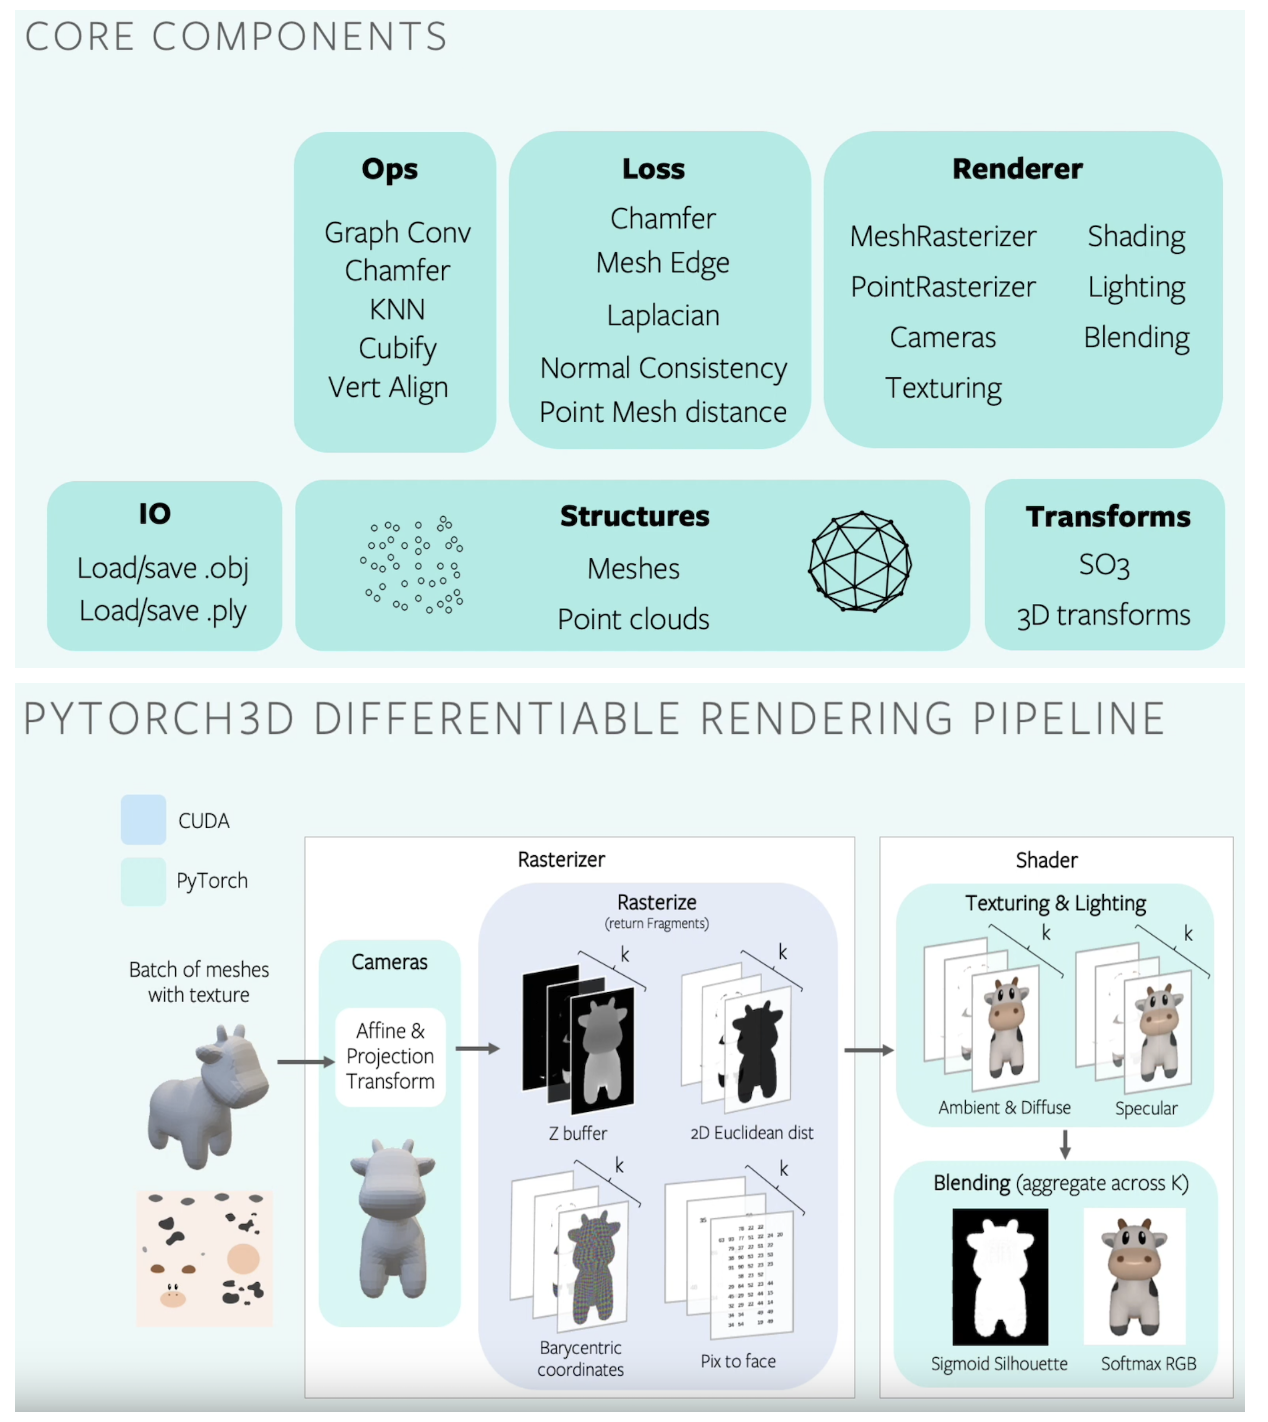
        <figcaption>(Source: SIGGRAPH 2020: 3D Deep Learning with Pytorch3D)
        </figcaption>
    </figure>
</center>

A normal Rendering Pipeline involves two stages:
- [ ] Rasterizer: This involves the conversion from the 3d shape to a 2d image. But this does not include the color shading.
- [ ] Shading: This involves the coloring of the images with each pixel value.

#### Step 2a: Rasterizer ####

So, first off we will do Rasterizer. As you can observe from the figure above, Rasterizer involves the development of the **camera** module. But why do we need a camera module? Well its very simple. Think of the world around us. Our world is 3D, but any image that we click with the camera of our phone is 2D. This is exactly what rasterization is, i.e., using a camera to enforce from 3d to 2d. But, one must remember that this doesn't add any colors. 

So to summarize, we need to do the following steps to get a 2d viewpoint of a 3d object.
- [x] Set the camera settings, i.e. where the camera is placed -- camera's distance from the object, camera's elevation angle and the camera's azimuth angle. This can be given as arguments to the <code>render.camera.look_at_view_transform()</code> method. 
- [x] Create a camera module using the <code>renderer.cameras.FoVPerspectiveCameras()</code> methods.
- [x] Create a rasterizer settings (using <code>pytorch3d.renderer.mesh.rasterizer.RasterizationSettings()</code> method) which sets the image dimensions and basic image modifications.
- [x] Setup the rasterizer using the <code>pytorch3d.renderer.mesh.rasterizer.MeshRasterizer</code>

In [3]:
## Setting up the camera ##
## We are going to follow the setup of Camera 1 of MVCNN paper ##

rotation , translation = look_at_view_transform(dist = 5 , 
                                                elev = 30. , 
                                                azim = 30.)

camera = FoVPerspectiveCameras(R = rotation , 
                               T = translation ,
                               device = 'cpu')


## Creating the Rasterization settings ##

rasterization_settings = RasterizationSettings(image_size = (256 , 256) , 
                                               blur_radius = 0. , 
                                               faces_per_pixel = 1)

## Finally creating the rasterizer object ##

rasterizer = MeshRasterizer(cameras = camera ,
                            raster_settings = rasterization_settings)

Now, we have everything needed to do rasterization. Thus, we move on to the next stage of Shading.

#### Step 2b: Shading ####

In this step we are going to do the shading bit of the rendering portion. This does somewhat of a color picking and derives the color that the rasterized image should hold.

Doing this is a bit more straight forward. Since we are trying to build up the shader as per the MVCNN paper we will use the Soft Phong Shader of the pytorch3d library given by the <code>pytorch3d.renderer.mesh.shader.SoftPhongShader</code> method. 

In [4]:
## Defining the Shader object ##

shader = SoftPhongShader(device = 'cpu' ,
                         cameras = camera)

And we are done. Now we are ready to render. We have perfectly set up the rendering pipeline with the Rasterization and the Rendering Shape. Now we just create a renderer object and see how our rendered image look. (* wink *)

#### Step 2c: Looking at the Rendered Image ####

In [5]:
## Setting up the renderer object ##

renderer = MeshRenderer(rasterizer = rasterizer ,
                        shader = shader)

Now lets see a rendered image.

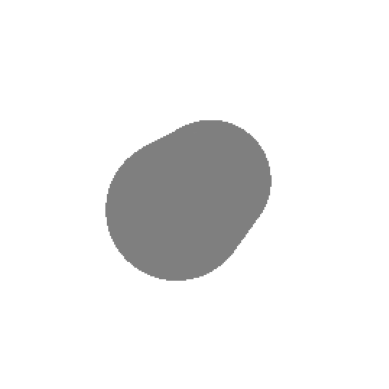

In [6]:
## Getting and viewing a rendered view ##

rendered_img = renderer(mesh)

img = rendered_img[0 , : , : , :3].cpu().numpy()

plt.imshow(img)
plt.grid("off");
plt.axis("off");
plt.show()

#### Step 3: Batching ####

Though we are done with rendering, we need to sort out the thing for batching. Since, this will act as a base for the MVCNN implementation in the next notebook, this batchwise implementation is really important.

In [7]:
## Creating batched implementation of rendered images from different elevation and azimuth ##

## Setting the batch size or the number of views ##

num_views = 12

## Splitting the elevation and azimuth into 12 values each ##

elevation = torch.linspace(start = 0 , end = 360 , steps = num_views)
azimuth = torch.linspace(start = -180 , end = 180 , steps = num_views)

## Setting up the camera ##
## We are going to update the rotation and translation and the camera settings ##

rotation , translation = look_at_view_transform(dist = 5. , 
                                                elev = elevation , 
                                                azim = azimuth)

camera = FoVPerspectiveCameras(R = rotation , 
                               T = translation ,
                               device = 'cpu')


## Creating the Rasterization settings ##

rasterization_settings = RasterizationSettings(image_size = (256 , 256) , 
                                               blur_radius = 0. , 
                                               faces_per_pixel = 1)

## Finally creating the rasterizer object ##

rasterizer = MeshRasterizer(cameras = camera ,
                            raster_settings = rasterization_settings)

## Defining the Shader object ##

shader = SoftPhongShader(device = 'cpu' ,
                         cameras = camera)


## Setting up the batch renderer object ##

batch_renderer = MeshRenderer(rasterizer = rasterizer ,
                        shader = shader)

## To create batches of multi-views we need to make separate copies of... ##
## mesh object. ##

batch_mesh = mesh.extend(num_views)

And we are done.

Now let's create the batched renderings.

In [8]:
## Batched renderings of multiple views ##

batched_renderings = batch_renderer(batch_mesh)

In [9]:
## Checking the shape of the renderings ##

batched_renderings.shape

torch.Size([12, 256, 256, 4])

Now lets visualize them. But first we must shift the channel dimesion to the 1st dimension.

In [10]:
## Changing the channel dimension ##

channel_shifted_batched_renderings = batched_renderings.permute(0 , 3 , 1 , 2)

channel_shifted_batched_renderings.shape

torch.Size([12, 4, 256, 256])

Now lets visualize.

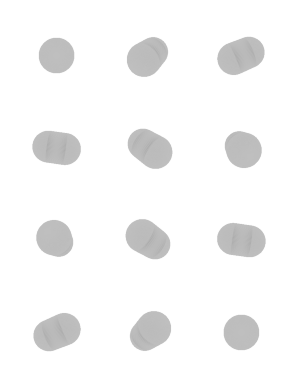

In [11]:
## Visualize ##
plt.imshow(make_grid(channel_shifted_batched_renderings , nrow = 3).permute(1 , 2 , 0))
plt.grid("off");
plt.axis("off");
plt.show()

Amazing! The rendered shape looks so nice! 

Hope this was of help to you.

See you in the next notebook, where we take all these and our knowledge of pytorch to implement MVCNN.